In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

from pathlib import Path
from copy import deepcopy
from torch.utils.tensorboard import SummaryWriter

In [3]:
import sys
sys.path.insert(0, './../')

In [4]:
import references_detection.transforms as TL
from references_detection.engine import evaluate
from references_detection.engine import train_one_epoch
from references_detection import utils
from references_detection import coco_utils

In [5]:
from src.visualization_tools import show_coco_dataset_item
from src.model import get_model_instance_segmentation
from src.train_tools import train_cycle
from src.test_tools import test_model_on_dataset, get_model_prediction_one_image
from src.visualization_tools import show_instance_segmentation_by_model_predictions

In [6]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

## Константы

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
num_classes = 2

In [9]:
val_num = 476

## Пути

In [10]:
data_path = Path('./../data')
cityscapes_dataset_path = data_path / 'cityscapes'
cityscapes_annotations_train = data_path / 'cityscapes/annotations/person_annotations_train.json'
eval_dataset_path = data_path / 'tiny'
eval_images = [eval_dataset_path / 'image_1.png', eval_dataset_path / 'image_4.png']
results_path = Path('./../results')

In [ ]:
tensorboard_tag = 'mask_rcnn_cityscapes_training'
model_results_path = results_path / tensorboard_tag
tensorboard_results_path = results_path / 'tensorboard' / tensorboard_tag
model_save_path = results_path / tensorboard_tag / 'models'
model_results_path.mkdir()
tensorboard_results_path.mkdir()
model_save_path.mkdir()

## Датасет

In [11]:
common_transforms = TL.Compose([coco_utils.ConvertCocoPolysToMask(), TL.ToTensor()])
train_transforms = TL.Compose([coco_utils.ConvertCocoPolysToMask(), TL.ToTensor(), TL.Resize(size=(512, 256)), \
                               TL.RandomHorizontalFlip()])

In [12]:
cityscapes_dataset = coco_utils.get_coco_subset_all_annotations(
    cityscapes_dataset_path, cityscapes_annotations_train, transforms=None
)

loading annotations into memory...
Done (t=1.43s)
creating index...
index created!


In [14]:
train_set, val_set = torch.utils.data.random_split(cityscapes_dataset, [len(cityscapes_dataset) - val_num, val_num])

In [15]:
train_set.dataset = deepcopy(cityscapes_dataset)
train_set.dataset.dataset._transforms = train_transforms
val_set.dataset.dataset._transforms = common_transforms

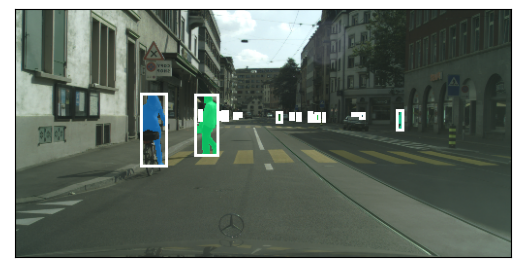

In [16]:
show_coco_dataset_item(train_set[0])
plt.show()

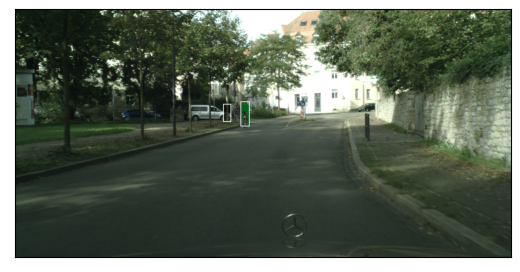

In [17]:
show_coco_dataset_item(val_set[0])
plt.show()

## Модель

In [18]:
model = get_model_instance_segmentation(num_classes)
model = model.to(device)

## Обучение

In [19]:
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)
data_loader_val = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-3)

writer = SummaryWriter(Path(results_path) / tensorboard_tag)

num_epochs = 10

train_cycle(model, num_epochs, optimizer, device, data_loader_train, data_loader_val, writer, \
            tensorboard_tag, model_save_pathб print_freq=100, save_model_freq=1, eval_images=eval_images)